# Load images from new Echelle

## Imports and Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
from lmfit.models import GaussianModel
from ipywidgets import interact,widgets

In [2]:
# Don't know how to import locally, so I just use %run
%run ../tools/echelle.py

In [3]:
files_fujii = {
    "orders": "pattern_fujii.txt",
    "wavelength": "wavelength_fujii.txt",
    "sphr": "Sep28_2022_175416_100ms_sekibunki.tif",
    "bkgr": "Sep28_2022_175455_100ms_sekibunki-dark.tif",
    "integral": "integrating_sphere.txt",
}
#wv = np.loadtxt('./data/fulcher-α_band_wavelength.txt')

In [4]:
%run ../tools/echelle.py
folder = './data'
#crop = [1400,2600]
#files_fujii['orders'] = "pattern_fujii.txt"
crop = [1300,2950]
files_fujii['orders'] = "pattern_fujii-1.txt"
cb = Calibrations(folder,files_fujii,spec='fujii',dv=17,crop=crop)
cb.start_cut()

In [5]:
bpth = folder
fname = 'Sep28_2022_175416_100ms_sekibunki.tif'
sphr = EchelleImage(os.path.join(bpth,fname),clbr=cb,spec='fujii',crop=crop)
fname = 'Sep28_2022_175455_100ms_sekibunki-dark.tif'
sphrbg = EchelleImage(os.path.join(bpth,fname),clbr=cb,spec='fujii',crop=crop)
sphr.calculate_order_spectra()
sphrbg.calculate_order_spectra()

In [6]:
h2 = EchelleImage('./data/H2-lamp-Fulcher-1s--20C.tif',clbr=cb,spec='fujii',crop=crop)
#h2 = EchelleImage('./data/Sep28_2022_174758_100ms_ThAr.tif',clbr=cb,spec='fujii',crop=crop)
#h2 = EchelleImage('./data/Sep29_2022_191811_5ms_FeNe.tif',clbr=cb,spec='fujii',crop=crop)
#h2 = EchelleImage('./data/Sep29_2022_191832_100ms_FeNe.tif',clbr=cb,spec='fujii',crop=crop)

h2.calculate_order_spectra()
subtract = [i.min() for i in h2.order_spectra[0]]

In [7]:
x = np.arange(cb.DIMW)
#orders = [3,4,5,6,7,8,9]
#orders = range(h2.order_spectra.shape[1])
orders = [10,11,12]

pg_data = []
for i,nord in enumerate(orders):
    pg_data.append(
        go.Scatter(
            x = x+1000*i + 3*i**2,
            y=(h2.order_spectra[0,nord]-subtract[nord])/sphr.order_spectra[0,nord]+3e-3*i,
            name = nord,
        )
    )

fig = go.Figure(data=pg_data)
fig.update_layout(template='plotly_white')
fig.show()

# Orders

In [12]:
#nord = 3
#orders = range(3,10)
orders = range(h2.order_spectra.shape[1])
def plotfunc(nord):
    x = np.arange(cb.DIMW)
    y = (h2.order_spectra[0,nord]-subtract[nord])/sphr.order_spectra[0,nord]

    pg_data = [go.Scatter(x=x,y=y,name = nord)]
    fig = go.Figure(data=pg_data)
    fig.update_layout(template='plotly_white')
    fig.show()

interact(plotfunc, nord = widgets.Dropdown(options=orders,value=3,description='order'))


interactive(children=(Dropdown(description='order', index=3, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

<function __main__.plotfunc(nord)>

center = 319.4924


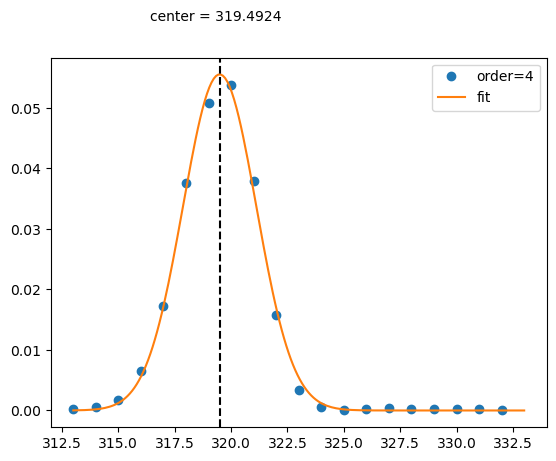

In [9]:
%matplotlib inline
nord = 4
x0 = 323
d=10

x = np.arange(cb.DIMW)
y = (h2.order_spectra[0,nord]-subtract[nord])/sphr.order_spectra[0,nord]

y = y[x0-d:x0+d]
y = y - y.min()
x = x[x0-d:x0+d]
plt.plot(x,y,'o',label=f'order={nord}')

gauss1 = GaussianModel(prefix='g1_')
pars = gauss1.guess(y, x=x)
mod = gauss1 
out = mod.fit(y, pars, x=x)

xlong = np.linspace(x0-d,x0+d,200)
plt.plot(xlong,mod.eval(out.params,x=xlong),label='fit')
center = out.params['g1_center'].value
plt.axvline(center,c='k',ls='--')
#txt = f'center = {center:.4f} wavelength = {wvs[nord][i]}'
txt = f'center = {center:.4f}'
ax = plt.gca()
ax.text(0.2,1.1,txt,transform=ax.transAxes)
plt.legend()
print(txt)

Text(0, 0.5, 'wavelength, nm')

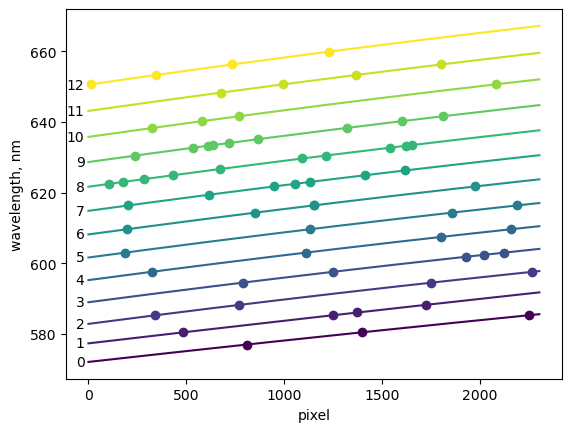

In [10]:
# Check Wavelength calibration
#fpth = '../resources/calibration_files/wavelength_fujii.txt'
fpth = './data/wavelength_fujii.txt'
#wcal = np.loadtxt(fpth, skiprows=2, usecols=(0, 1, 2, 3, 4))
wcal = pd.read_csv(fpth,sep='\t',comment='#',names=['ord','from','to','center','wavelength','band'])
%matplotlib inline
ab = lambda x: 1 if x < 3 else 2

orders = [0,1,2,3,4,5,6,7,8,9,10,11,12]
#orders = [2]
clrs = plt.cm.viridis(np.linspace(0, 1, len(orders)))
wfits = {}
ax = plt.gca()
for j,nord in enumerate(orders):
    p = wcal[wcal['ord']==nord]['center']
    w = wcal[wcal['ord']==nord]['wavelength']
    f = np.poly1d(np.polyfit(p,w,ab(len(p))))
    wfits[nord] = f
    x = np.arange(cb.DIMW)
    plt.plot(x,f(x),c=clrs[j],label=nord)
    plt.plot(p,w,'o',c=clrs[j])
    ax.text(-20,f(0),nord,ha='right',va='center')
#plt.legend(loc=1,bbox_to_anchor=[1.15,1])
plt.xlabel('pixel')
plt.ylabel('wavelength, nm')

In [11]:
x = np.arange(cb.DIMW)
#orders = [0,1,2,3,4,5,6,7,8,9]
orders = range(h2.order_spectra.shape[1])
pg_data = []
for nord in orders:
    f = wfits[nord]    
    pg_data.append(
        go.Scatter(
            x=f(x),
            y=(h2.order_spectra[0,nord]-subtract[nord])/sphr.order_spectra[0,nord],
            name = nord,
        )
    )

#pg_data = [go.Scatter(x=x,y=y,name = nord)]
fig = go.Figure(data=pg_data)
fig.update_layout(template='plotly_white')
fig.show()